In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Import custom data generation models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import data_gen_models as data

## Data generating model

We generate data from a toy model with 10 explanatory variables and a qualitative label for each sample, which is designed to mimic "heteroschedasticity" in a classification setting.
More precisely, the first variable controls the "noise level" in the label: small values of $X_0$ mean that all labels are more or less equally likely; large values of $X_0$ mean that one label is much more likely than the others (which one is determined by the other features).
To clarify, we visualize below the distribution of the true label probabilities (for one value of the label) as a function of $X_0$, which here can take only two possible values for simplicity. 

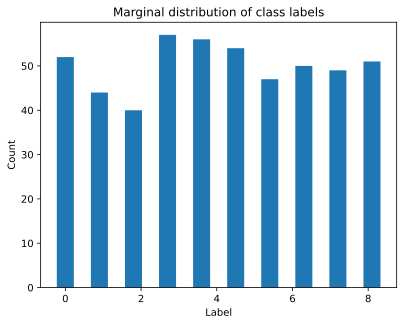

In [26]:
# Set a random seed for reproducibility
np.random.seed(2023)

# Pre-defined model
p = 10                                                  # Number of features
K = 10                                                  # Number of possible labels
data_model = data.Model_Class2(K,p)                    # Data generating model

# Sample data
n = 500                                                # Number of data samples
X_data = data_model.sample_X(n)                        # Generate the data features
Y_data = data_model.sample_Y(X_data)                   # Generate the data labels conditional on the features

# Sample test data
n_test = 1000                                          # Number of test samples
X_test = data_model.sample_X(n_test)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

# Plot the marginal distribution of the class labels
plt.hist(Y_data, bins=K, rwidth=0.5, align="left")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Marginal distribution of class labels")
plt.show()

## Oracle classifier

Let's apply the classification oracle we learnt about during the lecture.

In [27]:
from mfpi import classification

def oracle(pi, alpha, randomize=True):
    prediction_rule = classification.ProbabilityAccumulator(pi)
    S = prediction_rule.predict_sets(alpha)
    return S

# Compute true class probabilities for every sample
pi = data_model.compute_prob(X_test)

# Nominal coverage: 1-alpha 
alpha = 0.1

# Oracle prediction sets
S_oracle = oracle(pi, alpha)                  

Now we would like to evaluate the quality of the oracle predictions

In [28]:
def evaluate_predictions(S, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of classification predictions
    Computes:
    - marginal coverage
    - unbiased estimate of worst-slab coverage
    - average size of sets
    - average size of sets that contain the true Y
    
    Input
    S         : n - long list of prediction sets (each set is a discrete array)
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Estimate worst-slab coverage
    wsc_coverage = classification.wsc_unbiased(X, Y, S)
    
    # Number of samples
    n = len(Y)
    
    # Output placeholder
    marginal_coverage = None
    size = None
    size_cover = None
    
    # Compute marginal coverage
    marginal_coverage = np.mean([Y[i] in S[i] for i in range(n)])
    
    # Compute average size of prediction sets
    size = np.mean([len(S[i]) for i in range(n)])
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where([Y[i] in S[i] for i in range(n)])[0]
    size_cover = np.mean([len(S[i]) for i in idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('WS conditional coverage : {:2.3%}'.format(wsc_coverage))
        print('Average size            : {:2.3f}'.format(size))
        print('Average size | cover    : {:2.3f}'.format(size_cover))
        
    return marginal_coverage, wsc_coverage, size, size_cover

In [29]:
metrics = evaluate_predictions(S_oracle, X_test, Y_test)

Marginal coverage       : 92.700%
WS conditional coverage : 96.907%
Average size            : 2.620
Average size | cover    : 2.661


## Black-box classifier

We will use a multi-layer Perceptron classifier.
This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [30]:
from sklearn.neural_network import MLPClassifier

# Fit the black-box classifier
black_box = MLPClassifier(learning_rate_init = 0.01, max_iter = 1000, hidden_layer_sizes = 100, 
                          random_state = 2023)

black_box.fit(X_data, Y_data)

# Make point predictions for test data
Y_hat = black_box.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_hat))

              precision    recall  f1-score   support

           0       0.49      0.57      0.53       109
           1       0.50      0.45      0.47        94
           2       0.53      0.40      0.46        97
           3       0.42      0.39      0.41       107
           4       0.28      0.36      0.31        99
           5       0.35      0.38      0.36        95
           6       0.26      0.24      0.25       104
           7       0.25      0.28      0.27        88
           8       0.26      0.24      0.25        99
           9       0.42      0.37      0.39       108

    accuracy                           0.37      1000
   macro avg       0.38      0.37      0.37      1000
weighted avg       0.38      0.37      0.37      1000



We can extract conditional class probability estimates from this black-box model.

In [31]:
# Estimate class probabilities for test points 
pi_hat = black_box.predict_proba(X_test)
pi_hat.shape

(1000, 10)

Let's compare the estimated class probabilities to the true class probabilities.

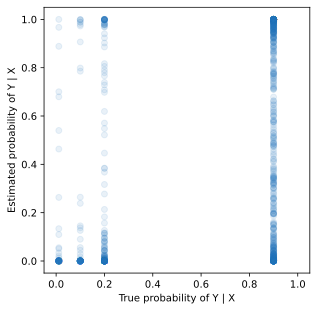

In [32]:
# Extract estimated probabilities for observed class
prob_est = np.array([pi_hat[i,Y_test[i]] for i in range(n_test)])
prob_est

# Compute true conditional probabilities from data generating model
prob_true = data_model.compute_prob(X_test)
prob_true = np.array([prob_true[i,Y_test[i]] for i in range(n_test)])

# Make scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(prob_true, prob_est, alpha=0.1)
ax.set_xlabel("True probability of Y | X")
ax.set_ylabel("Estimated probability of Y | X")
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
ax.set_aspect('equal', adjustable='box')
plt.show()

Clearly, the black-box classifier is over-confident.

Let's see what happens if we plug these probability estimates into the oracle classification rule.

In [33]:
# Black-box plugin prediction sets
S_plugin = None
S_plugin = oracle(pi_hat, alpha)

# Evaluate prediction sets
evaluate_predictions(S_plugin, X_test, Y_test)

Marginal coverage       : 48.200%
WS conditional coverage : 22.222%
Average size            : 1.514
Average size | cover    : 1.610


(0.482, 0.2222222222222222, 1.514, 1.6099585062240664)

## Split-conformal classification

In [35]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles
import pdb

def sc_classification(X, Y, X_test, alpha):
    """
    Compute split-conformal classification prediction sets.
    Uses neural network as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    S = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)
    
    # Fit a quantile regression model
    black_box = MLPClassifier(learning_rate_init = 0.01, max_iter = 1000, hidden_layer_sizes = 64, 
                              random_state = 2023)
    black_box.fit(X_train, Y_train)

    # Estimate class probabilities for calibration points
    pi_hat = black_box.predict_proba(X_calib)

    # Define prediction rule with plugin probability estimates
    prediction_rule = classification.ProbabilityAccumulator(pi_hat)
    
    # Compute conformity scores
    n_calib = len(Y_calib)
    epsilon = np.random.uniform(low=0.0, high=1.0, size=n_calib)
    scores = prediction_rule.calibrate_scores(Y_calib, epsilon = epsilon)
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (1 line)"""
    
    # Construct prediction sets for test data
    """TODO: write your code here (2 lines)"""
    
    return S

In [39]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal classification
S = sc_classification(X_data, Y_data, X_test, alpha)

# Evaluate prediction sets
metrics = evaluate_predictions(S, X_test, Y_test)

Marginal coverage       : 100.000%
WS conditional coverage : 100.000%
Average size            : 10.000
Average size | cover    : 10.000
